In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)4
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
def set_random_seed(seed=20):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_random_seed(20)


/kaggle/input/sp500-data/sp500_historical_data (2).csv
/kaggle/input/sp500-data/SP500 Vix (1).csv
/kaggle/input/our-data-15-3-2008-to-15-3-2024/Nifty 50 Historical Data (2).csv
/kaggle/input/our-data-15-3-2008-to-15-3-2024/BSE Sensex 30 Historical Data (3).csv
/kaggle/input/our-data-15-3-2008-to-15-3-2024/India VIX Historical Data (3).csv


# OUR RANGE: SENSEX (15-3-2008 to 15-3-2024)

In [ ]:
vix = pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/India VIX Historical Data (3).csv")
vix.drop("Vol.",axis=1,inplace=True)
vix["Change %"] = vix["Change %"].str.replace("%", "").astype(float)
vix.head(),vix.dtypes
data=pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/BSE Sensex 30 Historical Data (3).csv")
data=data[::-1]
data.reset_index(drop=True, inplace=True)
data.head()
data.nunique()

data.sort_index(axis=1,ascending=True)
data.rename(columns={'Price': 'Close'}, inplace=True)
df = data.copy()  # Ensure we don't modify the original dataset

# Convert financial columns to numeric (remove commas)
for col in ["Close", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

# Function to convert 'Vol.' column
def convert_volume(vol):
    if isinstance(vol, str):  # Ensure it's a string before replacing
        vol = vol.replace(",", "")  # Remove any thousand separators
        if "B" in vol:
            return float(vol.replace("B", "")) * 1_000_000_000
        elif "M" in vol:
            return float(vol.replace("M", "")) * 1_000_000
        elif "K" in vol:
            return float(vol.replace("K", "")) * 1_000
    return float(vol)  # Convert directly if already a number

df["Vol."] = df["Vol."].astype(str).apply(convert_volume)

# Convert 'Change %' column (remove '%' and convert to float)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)

# Print final DataFrame
print(df.dtypes)
print(df)

# Assign back to 'data' (if needed)
data = df

data = pd.merge(data, vix, on='Date', how='inner')
data.drop(['Date'], axis=1, inplace=True)
data.head()

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



# ---------------------------
# 2. Load & Preprocess Data
# ---------------------------
# For demonstration, we use a basic univariate "Close" series.
# Ensure that your DataFrame 'data' contains at least a "Close" column.
df = data[["Close"]].copy()
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df)

# ---------------------------
# 3. Create 15-day Sequences
# ---------------------------
def create_sequences(data, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df["Close"].values, time_steps=15)

# Split data: 70% train, 10% validation, 20% test.
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Reshape each sample to (time_steps, 1)
X_train = X_train.reshape(-1, 15, 1)
X_val   = X_val.reshape(-1, 15, 1)
X_test  = X_test.reshape(-1, 15, 1)

## with single LSTM model

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # Simple LSTM (unidirectional)
    x = LSTM(128, return_sequences=False, dropout=0.2)(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='tanh')(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    # Use the last day's price for final output calculation
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 15‑Day Branch with Bidirectional LSTM

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # 15-day full branch with BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='tanh')(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 15‑Day + 7‑Day Branch

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Gate the 7-day branch output
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    
    # Fuse the two branches
    fused_returns = Add()([long_term_return, gated_mid_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 7‑Day + 1‑Day Branch

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (last 1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Combine gated outputs
    fused_returns = Add()([gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 15‑Day + 1‑Day Branch

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm4_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Very recent branch (last 1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gate the 1-day branch output
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Fuse branches
    fused_returns = Add()([long_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm4_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## Full Model – 15‑Day + 7‑Day + 1‑Day Branch

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Fuse all branches
    fused_returns = Add()([long_term_return, gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


# OUR RANGE: NIFTY50 (15-3-2008 to 15-3-2024)

In [ ]:
vix = pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/India VIX Historical Data (3).csv")
vix.drop("Vol.",axis=1,inplace=True)
vix["Change %"] = vix["Change %"].str.replace("%", "").astype(float)
vix.head(),vix.dtypes
data=pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/Nifty 50 Historical Data (2).csv")
data=data[::-1]
data.reset_index(drop=True, inplace=True)
data.head()
data.nunique()

data.sort_index(axis=1,ascending=True)
data.rename(columns={'Price': 'Close'}, inplace=True)
df = data.copy()  # Ensure we don't modify the original dataset

# Convert financial columns to numeric (remove commas)
for col in ["Close", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

# Function to convert 'Vol.' column
def convert_volume(vol):
    if isinstance(vol, str):  # Ensure it's a string before replacing
        vol = vol.replace(",", "")  # Remove any thousand separators
        if "B" in vol:
            return float(vol.replace("B", "")) * 1_000_000_000
        elif "M" in vol:
            return float(vol.replace("M", "")) * 1_000_000
        elif "K" in vol:
            return float(vol.replace("K", "")) * 1_000
    return float(vol)  # Convert directly if already a number

df["Vol."] = df["Vol."].astype(str).apply(convert_volume)

# Convert 'Change %' column (remove '%' and convert to float)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)

# Print final DataFrame
print(df.dtypes)
print(df)

# Assign back to 'data' (if needed)
data = df

#data = pd.merge(data, vix, on='Date', how='inner')
data.drop(['Date'], axis=1, inplace=True)
data.head()

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ---------------------------
# 1. Set Seed for Reproducibility
# ---------------------------
def set_random_seed(seed=20):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_random_seed(20)

# ---------------------------
# 2. Load & Preprocess Data
# ---------------------------
# For demonstration, we use a basic univariate "Close" series.
# Ensure that your DataFrame 'data' contains at least a "Close" column.
df = data[["Close"]].copy()
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df)

# ---------------------------
# 3. Create 15-day Sequences
# ---------------------------
def create_sequences(data, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df["Close"].values, time_steps=15)

# Split data: 70% train, 10% validation, 20% test.
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Reshape each sample to (time_steps, 1)
X_train = X_train.reshape(-1, 15, 1)
X_val   = X_val.reshape(-1, 15, 1)
X_test  = X_test.reshape(-1, 15, 1)


## with single LSTM

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # Simple LSTM (unidirectional)
    x = LSTM(128, return_sequences=False, dropout=0.2)(inputs)
    x = Dense(16)(x)
    x = Dense(1,activation="tanh")(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    # Use the last day's price for final output calculation
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
vix = pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/India VIX Historical Data (3).csv")
vix.drop("Vol.",axis=1,inplace=True)
vix["Change %"] = vix["Change %"].str.replace("%", "").astype(float)
vix.head(),vix.dtypes
data=pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/Nifty 50 Historical Data (2).csv")
data=data[::-1]
data.reset_index(drop=True, inplace=True)
data.head()
data.nunique()

data.sort_index(axis=1,ascending=True)
data.rename(columns={'Price': 'Close'}, inplace=True)
df = data.copy()  # Ensure we don't modify the original dataset

# Convert financial columns to numeric (remove commas)
for col in ["Close", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

# Function to convert 'Vol.' column
def convert_volume(vol):
    if isinstance(vol, str):  # Ensure it's a string before replacing
        vol = vol.replace(",", "")  # Remove any thousand separators
        if "B" in vol:
            return float(vol.replace("B", "")) * 1_000_000_000
        elif "M" in vol:
            return float(vol.replace("M", "")) * 1_000_000
        elif "K" in vol:
            return float(vol.replace("K", "")) * 1_000
    return float(vol)  # Convert directly if already a number

df["Vol."] = df["Vol."].astype(str).apply(convert_volume)

# Convert 'Change %' column (remove '%' and convert to float)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)

# Print final DataFrame
print(df.dtypes)
print(df)

# Assign back to 'data' (if needed)
data = df

data = pd.merge(data, vix, on='Date', how='inner')
data.drop(['Date'], axis=1, inplace=True)
data.head()

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ---------------------------
# 1. Set Seed for Reproducibility
# ---------------------------
def set_random_seed(seed=20):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_random_seed(20)

# ---------------------------
# 2. Load & Preprocess Data
# ---------------------------
# For demonstration, we use a basic univariate "Close" series.
# Ensure that your DataFrame 'data' contains at least a "Close" column.
df = data[["Close"]].copy()
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df)

# ---------------------------
# 3. Create 15-day Sequences
# ---------------------------
def create_sequences(data, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df["Close"].values, time_steps=15)

# Split data: 70% train, 10% validation, 20% test.
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Reshape each sample to (time_steps, 1)
X_train = X_train.reshape(-1, 15, 1)
X_val   = X_val.reshape(-1, 15, 1)
X_test  = X_test.reshape(-1, 15, 1)



In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # Simple LSTM (unidirectional)
    x = LSTM(128, return_sequences=False, dropout=0.2)(inputs)
    x = Dense(16)(x)
    x = Dense(1,activation="tanh")(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    # Use the last day's price for final output calculation
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 15-Day Branch with Bidirectional LSTM

In [ ]:
from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # 15-day full branch with BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='tanh')(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 15-Day + 7-Day Branch

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Gate the 7-day branch output
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    
    # Fuse the two branches
    fused_returns = Add()([long_term_return, gated_mid_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 7-Day + 1-Day Branch

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (last 1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Combine gated outputs
    fused_returns = Add()([gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## 15-Day + 1-Day Branch

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm4_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Very recent branch (last 1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gate the 1-day branch output
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Fuse branches
    fused_returns = Add()([long_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm4_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## Full Model (15‑Day + 7‑Day + 1‑Day Branch)

In [ ]:
vix = pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/India VIX Historical Data (3).csv")
vix.drop("Vol.",axis=1,inplace=True)
vix["Change %"] = vix["Change %"].str.replace("%", "").astype(float)
vix.head(),vix.dtypes
data=pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/Nifty 50 Historical Data (2).csv")
data=data[::-1]
data.reset_index(drop=True, inplace=True)
data.head()
data.nunique()

data.sort_index(axis=1,ascending=True)
data.rename(columns={'Price': 'Close'}, inplace=True)
df = data.copy()  # Ensure we don't modify the original dataset

# Convert financial columns to numeric (remove commas)
for col in ["Close", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

# Function to convert 'Vol.' column
def convert_volume(vol):
    if isinstance(vol, str):  # Ensure it's a string before replacing
        vol = vol.replace(",", "")  # Remove any thousand separators
        if "B" in vol:
            return float(vol.replace("B", "")) * 1_000_000_000
        elif "M" in vol:
            return float(vol.replace("M", "")) * 1_000_000
        elif "K" in vol:
            return float(vol.replace("K", "")) * 1_000
    return float(vol)  # Convert directly if already a number

df["Vol."] = df["Vol."].astype(str).apply(convert_volume)

# Convert 'Change %' column (remove '%' and convert to float)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)

# Print final DataFrame
print(df.dtypes)
print(df)

# Assign back to 'data' (if needed)
data = df

data = pd.merge(data, vix, on='Date', how='inner')
data.drop(['Date'], axis=1, inplace=True)
data.head()

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ---------------------------
# 1. Set Seed for Reproducibility
# ---------------------------
def set_random_seed(seed=20):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_random_seed(20)

# ---------------------------
# 2. Load & Preprocess Data
# ---------------------------
# For demonstration, we use a basic univariate "Close" series.
# Ensure that your DataFrame 'data' contains at least a "Close" column.
df = data[["Close"]].copy()
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df)

# ---------------------------
# 3. Create 15-day Sequences
# ---------------------------
def create_sequences(data, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df["Close"].values, time_steps=15)

# Split data: 70% train, 10% validation, 20% test.
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Reshape each sample to (time_steps, 1)
X_train = X_train.reshape(-1, 15, 1)
X_val   = X_val.reshape(-1, 15, 1)
X_test  = X_test.reshape(-1, 15, 1)


In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Fuse all branches
    fused_returns = Add()([long_term_return, gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
vix = pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/India VIX Historical Data (3).csv")
vix.drop("Vol.",axis=1,inplace=True)
vix["Change %"] = vix["Change %"].str.replace("%", "").astype(float)
vix.head(),vix.dtypes
data=pd.read_csv("/kaggle/input/our-data-15-3-2008-to-15-3-2024/Nifty 50 Historical Data (2).csv")
data=data[::-1]
data.reset_index(drop=True, inplace=True)
data.head()
data.nunique()

data.sort_index(axis=1,ascending=True)
data.rename(columns={'Price': 'Close'}, inplace=True)
df = data.copy()  # Ensure we don't modify the original dataset

# Convert financial columns to numeric (remove commas)
for col in ["Close", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

# Function to convert 'Vol.' column
def convert_volume(vol):
    if isinstance(vol, str):  # Ensure it's a string before replacing
        vol = vol.replace(",", "")  # Remove any thousand separators
        if "B" in vol:
            return float(vol.replace("B", "")) * 1_000_000_000
        elif "M" in vol:
            return float(vol.replace("M", "")) * 1_000_000
        elif "K" in vol:
            return float(vol.replace("K", "")) * 1_000
    return float(vol)  # Convert directly if already a number

df["Vol."] = df["Vol."].astype(str).apply(convert_volume)

# Convert 'Change %' column (remove '%' and convert to float)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)

# Print final DataFrame
print(df.dtypes)
print(df)

# Assign back to 'data' (if needed)
data = df

#data = pd.merge(data, vix, on='Date', how='inner')
data.drop(['Date'], axis=1, inplace=True)
data.head()

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ---------------------------
# 1. Set Seed for Reproducibility
# ---------------------------
def set_random_seed(seed=20):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_random_seed(20)

# ---------------------------
# 2. Load & Preprocess Data
# ---------------------------
# For demonstration, we use a basic univariate "Close" series.
# Ensure that your DataFrame 'data' contains at least a "Close" column.
df = data[["Close"]].copy()
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df)

# ---------------------------
# 3. Create 15-day Sequences
# ---------------------------
def create_sequences(data, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df["Close"].values, time_steps=15)

# Split data: 70% train, 10% validation, 20% test.
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Reshape each sample to (time_steps, 1)
X_train = X_train.reshape(-1, 15, 1)
X_val   = X_val.reshape(-1, 15, 1)
X_test  = X_test.reshape(-1, 15, 1)


In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Fuse all branches
    fused_returns = Add()([long_term_return, gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


## OUR RANGE:SP500 (15-3-2008 to 15-3-2024)

- with single lstm

- - without vix

In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/sp500-data/SP500 Vix (1).csv")

# Ensure the required columns exist
if "Price" in df.columns and "Open" in df.columns:
    # Calculate the percentage change
    df["Change %"] = ((df["Price"] - df["Open"]) / df["Price"]) * 100

    # Save the updated CSV file
    # df.to_csv("SP 500 (2).csv", index=False)

    # Display first few rows
    print(df.head())
else:
    print("Error: CSV file must contain 'Price' and 'Open' columns.")
df.head()

         Date      Price       High        Low       Open  Vol.   Change %
0  17-03-2008  32.240002  35.599998  31.100000  35.139999     0  -8.995030
1  18-03-2008  25.790001  32.240002  25.580000  32.240002     0 -25.009696
2  19-03-2008  29.840000  29.950001  25.160000  25.780001     0  13.605896
3  20-03-2008  26.620001  29.840000  25.799999  29.840000     0 -12.096165
4  24-03-2008  25.730000  27.040001  24.750000  26.639999     0  -3.536727


,Date,Price,High,Low,Open,Vol.,Change %
0,17-03-2008,32.240002,35.599998,31.100000,35.139999,0,-8.995030
1,18-03-2008,25.790001,32.240002,25.580000,32.240002,0,-25.009696
2,19-03-2008,29.840000,29.950001,25.160000,25.780001,0,13.605896
3,20-03-2008,26.620001,29.840000,25.799999,29.840000,0,-12.096165
4,24-03-2008,25.730000,27.040001,24.750000,26.639999,0,-3.536727


In [2]:
import pandas as pd
import numpy as np
vix = df
vix.drop("Vol.",axis=1,inplace=True)
def convert_volume(val):
    if pd.isna(val) or val == '-':  # Handle NaN or '-' cases
        return np.nan
    val = val.strip().replace(',', '')  # Remove spaces & commas
    if val[-1] == 'K': return float(val[:-1]) * 1e3
    if val[-1] == 'M': return float(val[:-1]) * 1e6
    if val[-1] == 'B': return float(val[:-1]) * 1e9
    return float(val)

#vix["Vol."] = vix["Vol."].apply(convert_volume)
vix.rename(columns={'Open':'Vopen','High':'Vhigh','Low':'Vlow','Change %':'Vchange%'}, inplace=True)
vix["Vchange%"] = vix["Vchange%"].astype(str).str.replace("%", "").astype(float)
vix.head()

,Date,Price,Vhigh,Vlow,Vopen,Vchange%
0,17-03-2008,32.240002,35.599998,31.100000,35.139999,-8.995030
1,18-03-2008,25.790001,32.240002,25.580000,32.240002,-25.009696
2,19-03-2008,29.840000,29.950001,25.160000,25.780001,13.605896
3,20-03-2008,26.620001,29.840000,25.799999,29.840000,-12.096165
4,24-03-2008,25.730000,27.040001,24.750000,26.639999,-3.536727


In [3]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/sp500-data/sp500_historical_data (2).csv")

# Ensure the required columns exist
if "Price" in df.columns and "Open" in df.columns:
    # Calculate the percentage change
    df["Change %"] = ((df["Price"] - df["Open"]) / df["Price"]) * 100

    # Save the updated CSV file
    # df.to_csv("SP 500 (2).csv", index=False)

    # Display first few rows
    print(df.head())
else:
    print("Error: CSV file must contain 'Price' and 'Open' columns.")
df.head()

         Date        Price         High          Low         Open      Volume  \
0  17-03-2008  1276.599976  1287.500000  1256.979980  1283.209961  5683010000   
1  18-03-2008  1330.739990  1330.739990  1277.160034  1277.160034  5335630000   
2  19-03-2008  1298.420044  1341.510010  1298.420044  1330.969971  5358550000   
3  20-03-2008  1329.510010  1330.670044  1295.219971  1299.670044  6145220000   
4  24-03-2008  1349.880005  1359.680054  1330.290039  1330.290039  4499000000   

   Change %  
0 -0.517780  
1  4.026328  
2 -2.506887  
3  2.244433  
4  1.451238  


,Date,Price,High,Low,Open,Volume,Change %
0,17-03-2008,1276.599976,1287.500000,1256.979980,1283.209961,5683010000,-0.517780
1,18-03-2008,1330.739990,1330.739990,1277.160034,1277.160034,5335630000,4.026328
2,19-03-2008,1298.420044,1341.510010,1298.420044,1330.969971,5358550000,-2.506887
3,20-03-2008,1329.510010,1330.670044,1295.219971,1299.670044,6145220000,2.244433
4,24-03-2008,1349.880005,1359.680054,1330.290039,1330.290039,4499000000,1.451238


In [4]:
data=df
data=data[::-1]
data.reset_index(drop=True, inplace=True)
print(data.head())
data.nunique()

data.sort_index(axis=1,ascending=True)
data.rename(columns={'Price': 'Close'}, inplace=True)
df = data.copy()  # Ensure we don't modify the original dataset

# Convert financial columns to numeric (remove commas)
for col in ["Close", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

# Function to convert 'Vol.' column
#df.drop("Vol.",axis=1,inplace=True)

# Convert 'Change %' column (remove '%' and convert to float)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)

# Print final DataFrame
print(df.dtypes)
print(df)

# Assign back to 'data' (if needed)
data = df
#data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y")

# For 'vix', the date format is "MM/DD/YYYY"
#vix['Date'] = pd.to_datetime(vix['Date'], format="%m/%d/%Y")
#data = pd.merge(data, vix, on='Date', how='inner')
#row=data[data["Vol."].isna()]
data.drop(['Date'], axis=1, inplace=True)
data.head()

         Date        Price         High          Low         Open      Volume  \
0  14-03-2024  5150.479980  5176.850098  5123.299805  5175.140137  4687970000   
1  13-03-2024  5165.310059  5179.140137  5151.879883  5173.490234  4282890000   
2  12-03-2024  5175.270020  5179.870117  5114.479980  5134.299805  4080510000   
3  11-03-2024  5117.939941  5124.660156  5091.140137  5111.959961  3896430000   
4  08-03-2024  5123.689941  5189.259766  5117.500000  5164.459961  4208870000   

   Change %  
0 -0.478793  
1 -0.158368  
2  0.791654  
3  0.116843  
4 -0.795716  
Date         object
Close       float64
High        float64
Low         float64
Open        float64
Volume        int64
Change %    float64
dtype: object
            Date        Close         High          Low         Open  \
0     14-03-2024  5150.479980  5176.850098  5123.299805  5175.140137   
1     13-03-2024  5165.310059  5179.140137  5151.879883  5173.490234   
2     12-03-2024  5175.270020  5179.870117  5114.479980  51

,Close,High,Low,Open,Volume,Change %
0,5150.479980,5176.850098,5123.299805,5175.140137,4687970000,-0.478793
1,5165.310059,5179.140137,5151.879883,5173.490234,4282890000,-0.158368
2,5175.270020,5179.870117,5114.479980,5134.299805,4080510000,0.791654
3,5117.939941,5124.660156,5091.140137,5111.959961,3896430000,0.116843
4,5123.689941,5189.259766,5117.500000,5164.459961,4208870000,-0.795716


In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



# ---------------------------
# 2. Load & Preprocess Data
# ---------------------------
# For demonstration, we use a basic univariate "Close" series.
# Ensure that your DataFrame 'data' contains at least a "Close" column.
df = data[["Close"]].copy()
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df)

# ---------------------------
# 3. Create 15-day Sequences
# ---------------------------
def create_sequences(data, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df["Close"].values, time_steps=15)

# Split data: 70% train, 10% validation, 20% test.
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Reshape each sample to (time_steps, 1)
X_train = X_train.reshape(-1, 15, 1)
X_val   = X_val.reshape(-1, 15, 1)
X_test  = X_test.reshape(-1, 15, 1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 128)            │         66,560 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │          2,064 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             17 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 1)              │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1)              │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 1)              │              0 │ lambda_4[0][0],        │
│                           │                        │                │ lambda_3[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 68,641 (268.13 KB)

 Trainable params: 68,641 (268.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.2971e-05 - val_loss: 1.2279e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8638e-05 - val_loss: 1.2252e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7381e-05 - val_loss: 1.2335e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6233e-05 - val_loss: 1.2255e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6239e-05 - val_loss: 1.2275e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5950e-05 - val_loss: 1.2366e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5633e-05 - val_loss: 1.2259e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5495e-05 - val_loss: 1.2257e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5567e-05 - val_loss: 1.2295e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5320e-05 - val_loss: 1.2263e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

<Figure size 1200x600 with 0 Axes>

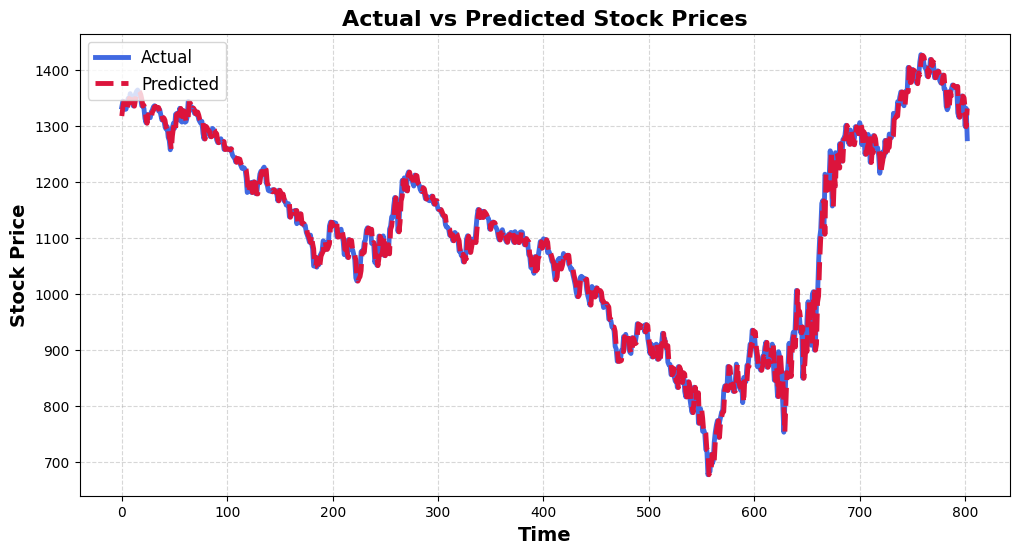

In [9]:

from tensorflow.keras.layers import Multiply, Activation

def build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # Simple LSTM (unidirectional)
    x = LSTM(128, return_sequences=False, dropout=0.2)(inputs)
    x = Dense(16)(x)
    x = Dense(1,activation="tanh")(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    # Use the last day's price for final output calculation
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility 


plt.figure(figsize=(12, 6))

num_points = max(100, len(y_test_inv))

# Actual: Royal Blue
plt.plot(
    y_test_inv[:num_points], 
    label="Actual", 
    linestyle="-", 
    linewidth=3.5,  
    color="#4169E1"  # Royal Blue
)

# Predicted: Crimson Red
plt.plot(
    y_pred_inv[:num_points], 
    label="Predicted", 
    linestyle="--",  
    linewidth=3.5,  
    color="#DC143C"  # Crimson Red
)

plt.xlabel("Time", fontsize=14, fontweight="bold")
plt.ylabel("Stock Price", fontsize=14, fontweight="bold")
plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight="bold")

plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256)            │        133,120 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │         16,448 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             65 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 1)              │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1)              │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_8 (Lambda)         │ (None, 1)              │              0 │ lambda_7[0][0],        │
│                           │                        │                │ lambda_6[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 149,633 (584.50 KB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.9822e-05 - val_loss: 1.2258e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.5212e-05 - val_loss: 1.2261e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/

<Figure size 1200x600 with 0 Axes>

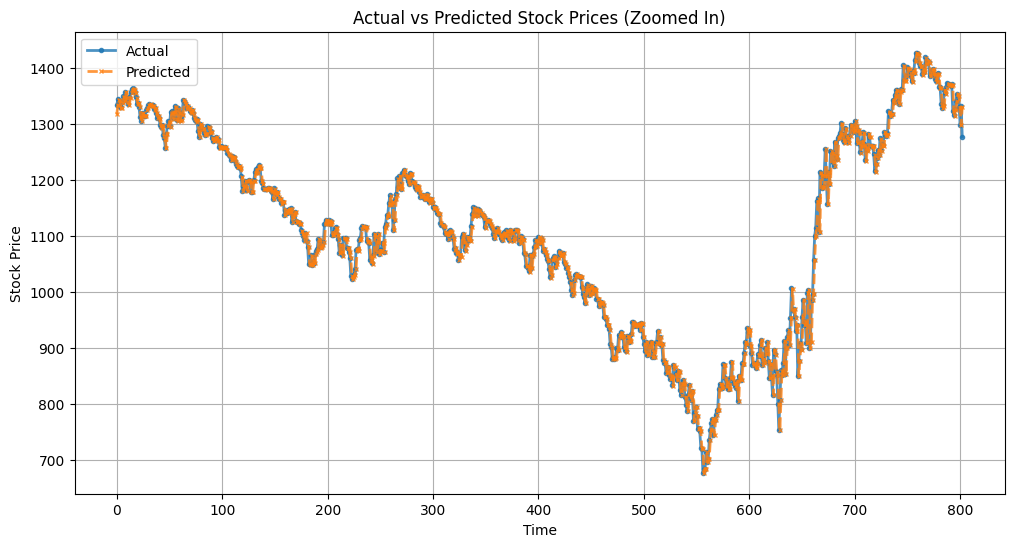

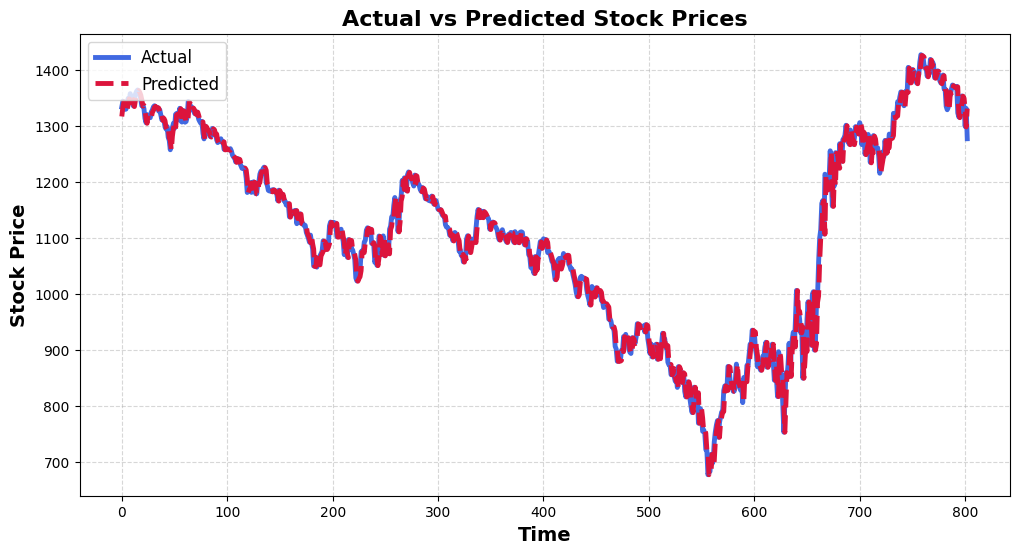

In [10]:
from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # 15-day full branch with BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='tanh')(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
plt.figure(figsize=(12, 6))

num_points = max(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8, color="#1f77b4")
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8, color="#ff7f0e")

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 6))

num_points = max(100, len(y_test_inv))

# Actual: Royal Blue
plt.plot(
    y_test_inv[:num_points], 
    label="Actual", 
    linestyle="-", 
    linewidth=3.5,  
    color="#4169E1"  # Royal Blue
)

# Predicted: Crimson Red
plt.plot(
    y_pred_inv[:num_points], 
    label="Predicted", 
    linestyle="--",  
    linewidth=3.5,  
    color="#DC143C"  # Crimson Red
)

plt.xlabel("Time", fontsize=14, fontweight="bold")
plt.ylabel("Stock Price", fontsize=14, fontweight="bold")
plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight="bold")

plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_10 (Lambda)        │ (None, 7, 1)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 256)            │        133,120 │ lambda_10[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │         16,448 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        133,120 │ input_layer_3[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │         16,448 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_11 (Lambda)        │ (None, 1)              │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             65 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │              2 │ lambda_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_9 (Lambda)         │ (None, 1)              │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1)              │              0 │ lambda_11[0][0],       │
│                           │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1)              │              0 │ lambda_9[0][0],        │
│                           │                        │                │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 32)             │             64 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 1)              │             33 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_13 (Lambda)        │ (None, 1)              │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_12 (Lambda)        │ (None, 1)              │              0 │ dense_12[0][0]         │
├──────────────────────

 Total params: 299,365 (1.14 MB)

 Trainable params: 299,365 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 5.5398e-05 - val_loss: 1.2263e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4914e-05 - val_loss: 1.2261e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━

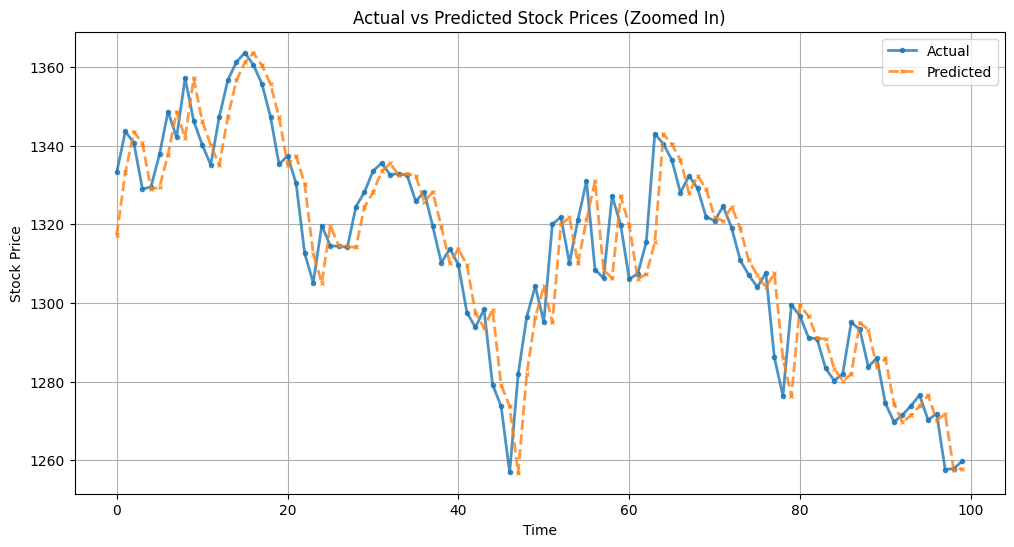

In [11]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Gate the 7-day branch output
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    
    # Fuse the two branches
    fused_returns = Add()([long_term_return, gated_mid_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_15 (Lambda)        │ (None, 7, 1)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_17 (Lambda)        │ (None, 1, 1)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 256)            │        133,120 │ lambda_15[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1)              │              0 │ lambda_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 32)             │             64 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 1)              │             65 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │             33 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_16 (Lambda)        │ (None, 1)              │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_18 (Lambda)        │ (None, 1)              │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1)              │              2 │ lambda_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1)              │              2 │ lambda_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 1)              │              0 │ lambda_16[0][0],       │
│                           │                        │                │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 1)              │              0 │ lambda_18[0][0],       │
│                           │                        │                │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1)              │              0 │ multiply_1[0][0],      │
│                           │                        │                │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 32)             │             64 │ add_1[0][0]            │
├──────────────────────

 Total params: 149,831 (585.28 KB)

 Trainable params: 149,831 (585.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 5.5441e-05 - val_loss: 1.2261e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms

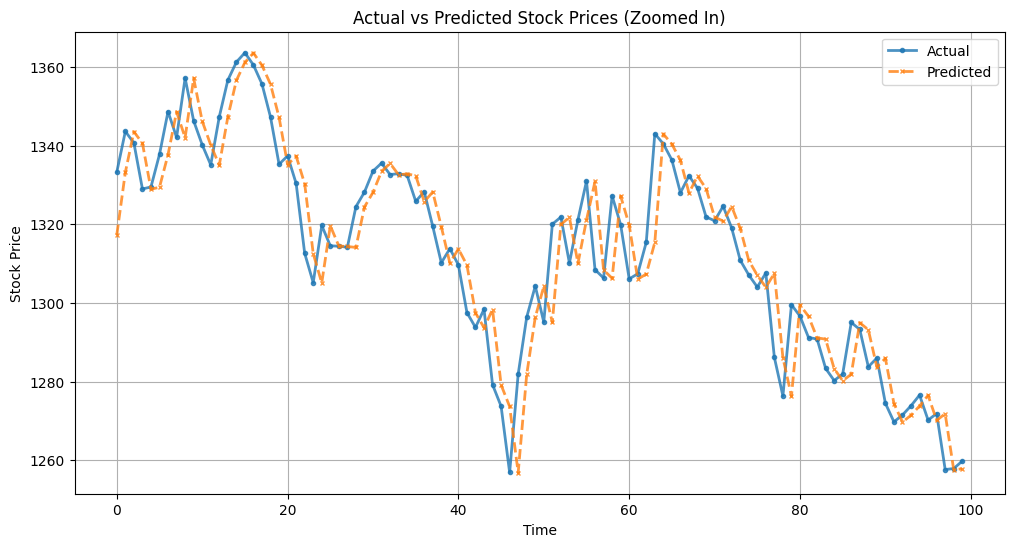

In [12]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (last 1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Combine gated outputs
    fused_returns = Add()([gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_23 (Lambda)        │ (None, 7, 1)           │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_25 (Lambda)        │ (None, 1, 1)           │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 256)            │        133,120 │ lambda_23[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1)              │              0 │ lambda_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 32)             │             64 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 256)            │        133,120 │ input_layer_5[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1)              │             65 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 1)              │             33 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_24 (Lambda)        │ (None, 1)              │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_26 (Lambda)        │ (None, 1)              │              0 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 1)              │             65 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 1)              │              2 │ lambda_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 1)              │              2 │ lambda_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_22 (Lambda)        │ (None, 1)              │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 1)              │              0 │ lambda_24[0][0],       │
│                      

 Total params: 299,464 (1.14 MB)

 Trainable params: 299,464 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 5.5043e-05 - val_loss: 1.2280e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4978e-05 - val_loss: 1.2263e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4901e-05 - val_loss: 1.2262e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━

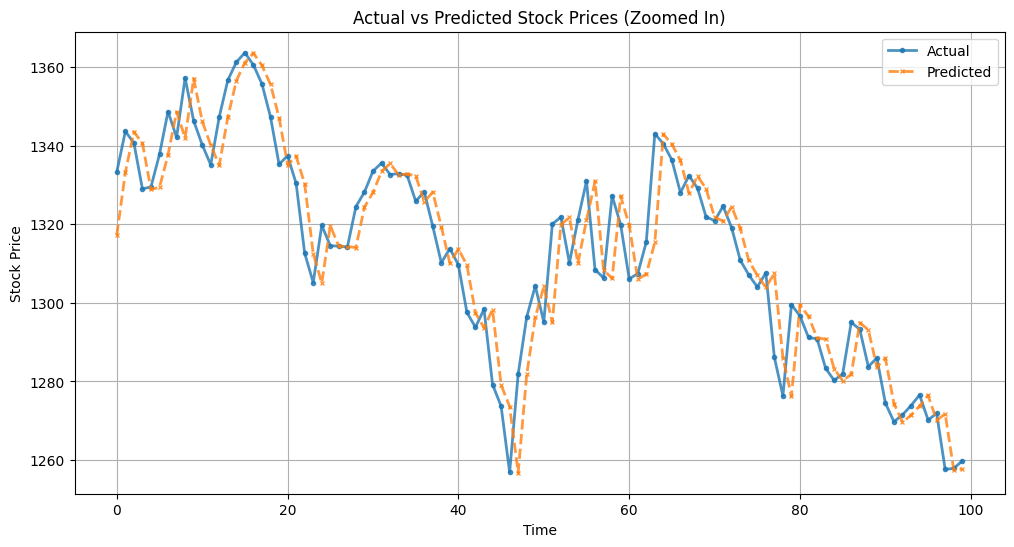

In [13]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Fuse all branches
    fused_returns = Add()([long_term_return, gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


- with vix

In [14]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/sp500-data/SP500 Vix (1).csv")

# Ensure the required columns exist
if "Price" in df.columns and "Open" in df.columns:
    # Calculate the percentage change
    df["Change %"] = ((df["Price"] - df["Open"]) / df["Price"]) * 100

    # Save the updated CSV file
    # df.to_csv("SP 500 (2).csv", index=False)

    # Display first few rows
    print(df.head())
else:
    print("Error: CSV file must contain 'Price' and 'Open' columns.")
df.head()

         Date      Price       High        Low       Open  Vol.   Change %
0  17-03-2008  32.240002  35.599998  31.100000  35.139999     0  -8.995030
1  18-03-2008  25.790001  32.240002  25.580000  32.240002     0 -25.009696
2  19-03-2008  29.840000  29.950001  25.160000  25.780001     0  13.605896
3  20-03-2008  26.620001  29.840000  25.799999  29.840000     0 -12.096165
4  24-03-2008  25.730000  27.040001  24.750000  26.639999     0  -3.536727


,Date,Price,High,Low,Open,Vol.,Change %
0,17-03-2008,32.240002,35.599998,31.100000,35.139999,0,-8.995030
1,18-03-2008,25.790001,32.240002,25.580000,32.240002,0,-25.009696
2,19-03-2008,29.840000,29.950001,25.160000,25.780001,0,13.605896
3,20-03-2008,26.620001,29.840000,25.799999,29.840000,0,-12.096165
4,24-03-2008,25.730000,27.040001,24.750000,26.639999,0,-3.536727


In [15]:
import pandas as pd
import numpy as np
vix = df
vix.drop("Vol.",axis=1,inplace=True)
def convert_volume(val):
    if pd.isna(val) or val == '-':  # Handle NaN or '-' cases
        return np.nan
    val = val.strip().replace(',', '')  # Remove spaces & commas
    if val[-1] == 'K': return float(val[:-1]) * 1e3
    if val[-1] == 'M': return float(val[:-1]) * 1e6
    if val[-1] == 'B': return float(val[:-1]) * 1e9
    return float(val)

#vix["Vol."] = vix["Vol."].apply(convert_volume)
vix.rename(columns={'Open':'Vopen','High':'Vhigh','Low':'Vlow','Change %':'Vchange%'}, inplace=True)
vix["Vchange%"] = vix["Vchange%"].astype(str).str.replace("%", "").astype(float)
vix.head()

,Date,Price,Vhigh,Vlow,Vopen,Vchange%
0,17-03-2008,32.240002,35.599998,31.100000,35.139999,-8.995030
1,18-03-2008,25.790001,32.240002,25.580000,32.240002,-25.009696
2,19-03-2008,29.840000,29.950001,25.160000,25.780001,13.605896
3,20-03-2008,26.620001,29.840000,25.799999,29.840000,-12.096165
4,24-03-2008,25.730000,27.040001,24.750000,26.639999,-3.536727


In [16]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/sp500-data/sp500_historical_data (2).csv")

# Ensure the required columns exist
if "Price" in df.columns and "Open" in df.columns:
    # Calculate the percentage change
    df["Change %"] = ((df["Price"] - df["Open"]) / df["Price"]) * 100

    # Save the updated CSV file
    # df.to_csv("SP 500 (2).csv", index=False)

    # Display first few rows
    print(df.head())
else:
    print("Error: CSV file must contain 'Price' and 'Open' columns.")
df.head()

         Date        Price         High          Low         Open      Volume  \
0  17-03-2008  1276.599976  1287.500000  1256.979980  1283.209961  5683010000   
1  18-03-2008  1330.739990  1330.739990  1277.160034  1277.160034  5335630000   
2  19-03-2008  1298.420044  1341.510010  1298.420044  1330.969971  5358550000   
3  20-03-2008  1329.510010  1330.670044  1295.219971  1299.670044  6145220000   
4  24-03-2008  1349.880005  1359.680054  1330.290039  1330.290039  4499000000   

   Change %  
0 -0.517780  
1  4.026328  
2 -2.506887  
3  2.244433  
4  1.451238  


,Date,Price,High,Low,Open,Volume,Change %
0,17-03-2008,1276.599976,1287.500000,1256.979980,1283.209961,5683010000,-0.517780
1,18-03-2008,1330.739990,1330.739990,1277.160034,1277.160034,5335630000,4.026328
2,19-03-2008,1298.420044,1341.510010,1298.420044,1330.969971,5358550000,-2.506887
3,20-03-2008,1329.510010,1330.670044,1295.219971,1299.670044,6145220000,2.244433
4,24-03-2008,1349.880005,1359.680054,1330.290039,1330.290039,4499000000,1.451238


In [17]:
data=df
data=data[::-1]
data.reset_index(drop=True, inplace=True)
print(data.head())
data.nunique()

data.sort_index(axis=1,ascending=True)
data.rename(columns={'Price': 'Close'}, inplace=True)
df = data.copy()  # Ensure we don't modify the original dataset

# Convert financial columns to numeric (remove commas)
for col in ["Close", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)

# Function to convert 'Vol.' column
#df.drop("Vol.",axis=1,inplace=True)

# Convert 'Change %' column (remove '%' and convert to float)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)

# Print final DataFrame
print(df.dtypes)
print(df)

# Assign back to 'data' (if needed)
data = df
#data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y")

# For 'vix', the date format is "MM/DD/YYYY"
#vix['Date'] = pd.to_datetime(vix['Date'], format="%m/%d/%Y")
data = pd.merge(data, vix, on='Date', how='inner')
#row=data[data["Vol."].isna()]
data.drop(['Date'], axis=1, inplace=True)
data.head()

         Date        Price         High          Low         Open      Volume  \
0  14-03-2024  5150.479980  5176.850098  5123.299805  5175.140137  4687970000   
1  13-03-2024  5165.310059  5179.140137  5151.879883  5173.490234  4282890000   
2  12-03-2024  5175.270020  5179.870117  5114.479980  5134.299805  4080510000   
3  11-03-2024  5117.939941  5124.660156  5091.140137  5111.959961  3896430000   
4  08-03-2024  5123.689941  5189.259766  5117.500000  5164.459961  4208870000   

   Change %  
0 -0.478793  
1 -0.158368  
2  0.791654  
3  0.116843  
4 -0.795716  
Date         object
Close       float64
High        float64
Low         float64
Open        float64
Volume        int64
Change %    float64
dtype: object
            Date        Close         High          Low         Open  \
0     14-03-2024  5150.479980  5176.850098  5123.299805  5175.140137   
1     13-03-2024  5165.310059  5179.140137  5151.879883  5173.490234   
2     12-03-2024  5175.270020  5179.870117  5114.479980  51

,Close,High,Low,Open,Volume,Change %,Price,Vhigh,Vlow,Vopen,Vchange%
0,5150.479980,5176.850098,5123.299805,5175.140137,4687970000,-0.478793,14.40,15.330000,13.42,13.62,5.416665
1,5165.310059,5179.140137,5151.879883,5173.490234,4282890000,-0.158368,13.75,14.040000,13.67,13.89,-1.018184
2,5175.270020,5179.870117,5114.479980,5134.299805,4080510000,0.791654,13.84,15.200000,13.81,14.97,-8.164741
3,5117.939941,5124.660156,5091.140137,5111.959961,3896430000,0.116843,15.22,16.040001,15.13,15.51,-1.905387
4,5123.689941,5189.259766,5117.500000,5164.459961,4208870000,-0.795716,14.74,15.530000,13.97,14.22,3.527812


In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Lambda, Concatenate, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# ---------------------------
# 2. Load & Preprocess Data
# ---------------------------
# For demonstration, we use a basic univariate "Close" series.
# Ensure that your DataFrame 'data' contains at least a "Close" column.
df = data[["Close"]].copy()
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df)

# ---------------------------
# 3. Create 15-day Sequences
# ---------------------------
def create_sequences(data, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df["Close"].values, time_steps=15)

# Split data: 70% train, 10% validation, 20% test.
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Reshape each sample to (time_steps, 1)
X_train = X_train.reshape(-1, 15, 1)
X_val   = X_val.reshape(-1, 15, 1)
X_test  = X_test.reshape(-1, 15, 1)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 128)            │         66,560 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 16)             │          2,064 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 1)              │             17 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_31 (Lambda)        │ (None, 1)              │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_30 (Lambda)        │ (None, 1)              │              0 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_32 (Lambda)        │ (None, 1)              │              0 │ lambda_31[0][0],       │
│                           │                        │                │ lambda_30[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 68,641 (268.13 KB)

 Trainable params: 68,641 (268.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.7594e-05 - val_loss: 1.2570e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8961e-05 - val_loss: 1.2455e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6951e-05 - val_loss: 1.2690e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6836e-05 - val_loss: 1.2312e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6246e-05 - val_loss: 1.2280e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5895e-05 - val_loss: 1.2258e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5854e-05 - val_loss: 1.2310e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.5642e-05 - val_loss: 1.2261e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.5359e-05 - val_loss: 1.2262e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5293e-05 - val_loss: 1.2252e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

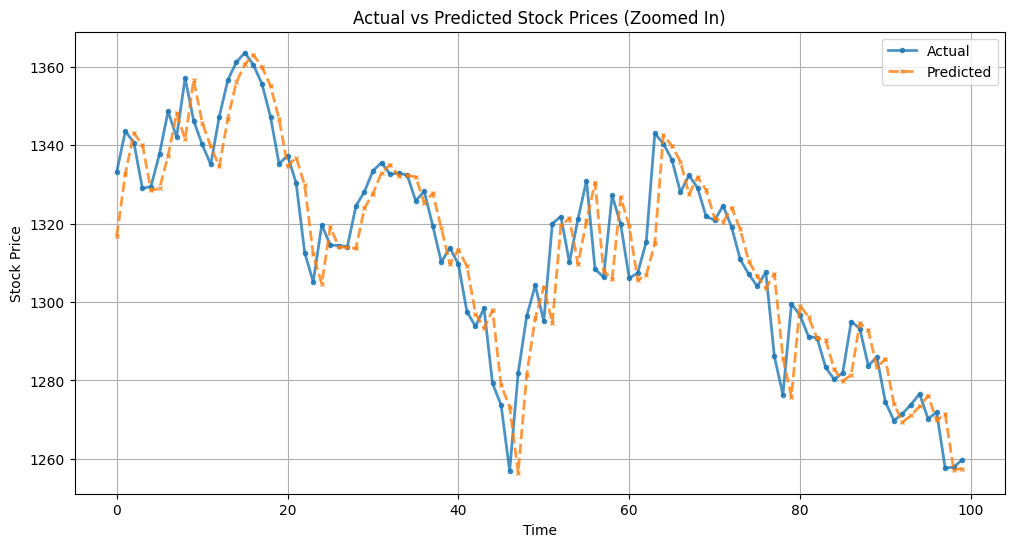

In [19]:

from tensorflow.keras.layers import Multiply, Activation

def build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # Simple LSTM (unidirectional)
    x = LSTM(128, return_sequences=False, dropout=0.2)(inputs)
    x = Dense(16)(x)
    x = Dense(1,activation="tanh")(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    # Use the last day's price for final output calculation
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_lstm_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 256)            │        133,120 │ input_layer_7[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 1)              │             65 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_34 (Lambda)        │ (None, 1)              │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_33 (Lambda)        │ (None, 1)              │              0 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_35 (Lambda)        │ (None, 1)              │              0 │ lambda_34[0][0],       │
│                           │                        │                │ lambda_33[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 149,633 (584.50 KB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.8692e-05 - val_loss: 1.2408e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.7202e-05 - val_loss: 1.2251e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.5418e-05 - val_loss: 1.2261e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4907e-05 - val_loss: 1.2261e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4907e-05 - val_loss: 1.2261e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/

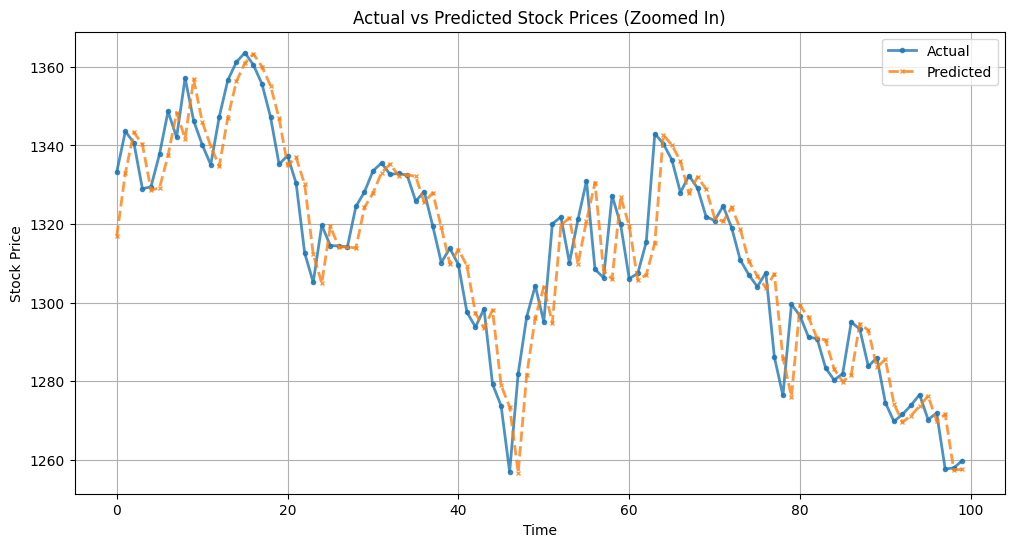

In [20]:
from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    # 15-day full branch with BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='tanh')(x)
    x = Lambda(lambda x: x * scale_factor)(x)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, x])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm1_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_37 (Lambda)        │ (None, 7, 1)           │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_8           │ (None, 256)            │        133,120 │ lambda_37[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 256)            │        133,120 │ input_layer_8[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 1)              │             65 │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_38 (Lambda)        │ (None, 1)              │              0 │ dense_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 1)              │             65 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 1)              │              2 │ lambda_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_36 (Lambda)        │ (None, 1)              │              0 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_5 (Multiply)     │ (None, 1)              │              0 │ lambda_38[0][0],       │
│                           │                        │                │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 1)              │              0 │ lambda_36[0][0],       │
│                           │                        │                │ multiply_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 32)             │             64 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 1)              │             33 │ dense_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_40 (Lambda)        │ (None, 1)              │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_39 (Lambda)        │ (None, 1)              │              0 │ dense_41[0][0]         │
├──────────────────────

 Total params: 299,365 (1.14 MB)

 Trainable params: 299,365 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 5.5599e-05 - val_loss: 1.2264e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4912e-05 - val_loss: 1.2265e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.5130e-05 - val_loss: 1.2269e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4893e-05 - val_loss: 1.2261e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4914e-05 - val_loss: 1.2271e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4963e-05 - val_loss: 1.2260e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4830e-05 - val_loss: 1.2262e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4998e-05 - val_loss: 1.2262e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4925e-05 - val_loss: 1.2266e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.4938e-05 - val_loss: 1.2264e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━

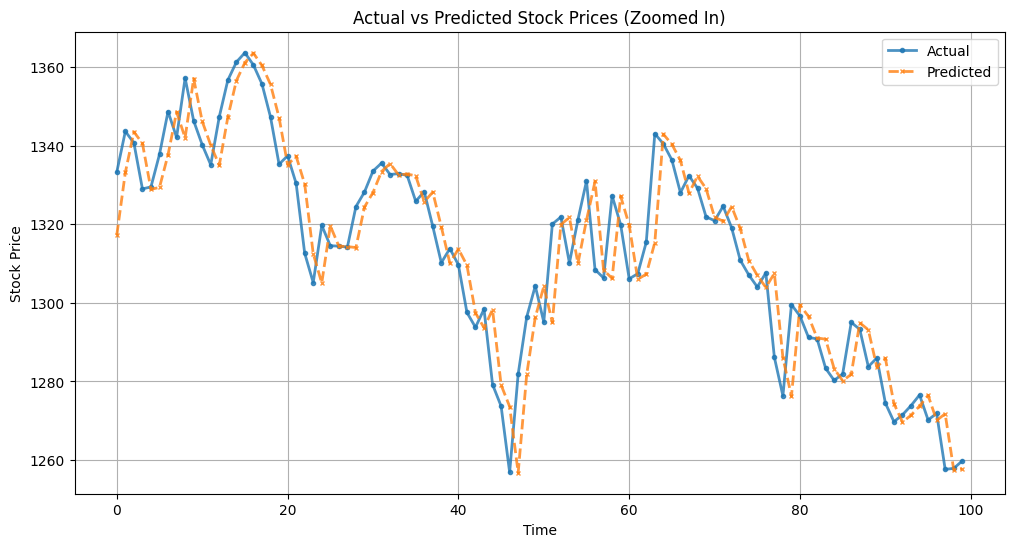

In [21]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Gate the 7-day branch output
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    
    # Fuse the two branches
    fused_returns = Add()([long_term_return, gated_mid_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm2_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_42 (Lambda)        │ (None, 7, 1)           │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_44 (Lambda)        │ (None, 1, 1)           │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 256)            │        133,120 │ lambda_42[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1)              │              0 │ lambda_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 32)             │             64 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 1)              │             65 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 1)              │             33 │ dense_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_43 (Lambda)        │ (None, 1)              │              0 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_45 (Lambda)        │ (None, 1)              │              0 │ dense_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 1)              │              2 │ lambda_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 1)              │              2 │ lambda_45[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_6 (Multiply)     │ (None, 1)              │              0 │ lambda_43[0][0],       │
│                           │                        │                │ dense_46[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_7 (Multiply)     │ (None, 1)              │              0 │ lambda_45[0][0],       │
│                           │                        │                │ dense_47[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 1)              │              0 │ multiply_6[0][0],      │
│                           │                        │                │ multiply_7[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 32)             │             64 │ add_4[0][0]            │
├──────────────────────

 Total params: 149,831 (585.28 KB)

 Trainable params: 149,831 (585.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 5.5060e-05 - val_loss: 1.2276e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4883e-05 - val_loss: 1.2259e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4956e-05 - val_loss: 1.2263e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4920e-05 - val_loss: 1.2264e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4948e-05 - val_loss: 1.2264e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4927e-05 - val_loss: 1.2265e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4936e-05 - val_loss: 1.2264e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4923e-05 - val_loss: 1.2264e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4939e-05 - val_loss: 1.2264e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4942e-05 - val_loss: 1.2263e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/

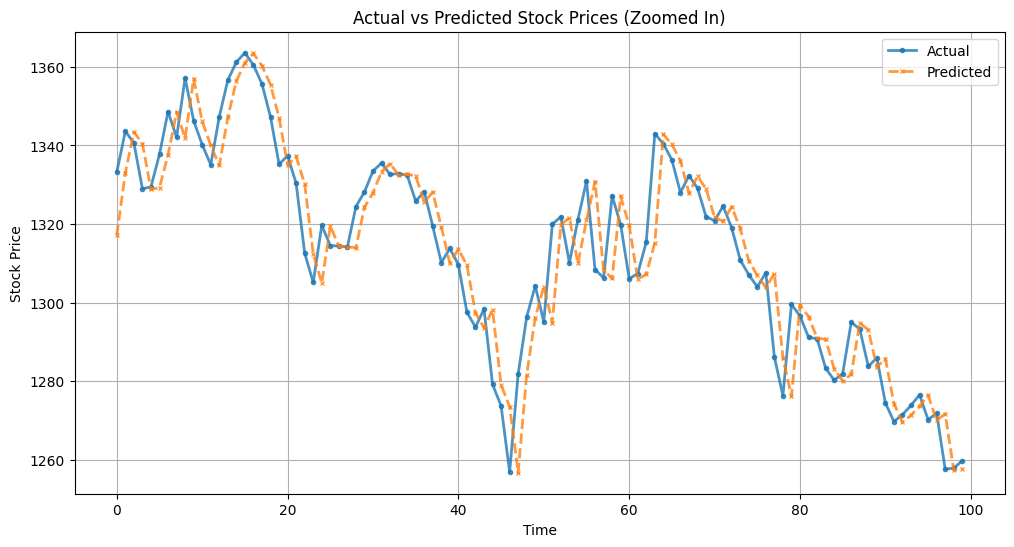

In [22]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Recent branch (last 7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (last 1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Combine gated outputs
    fused_returns = Add()([gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm3_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_50 (Lambda)        │ (None, 7, 1)           │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_52 (Lambda)        │ (None, 1, 1)           │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_11          │ (None, 256)            │        133,120 │ lambda_50[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 1)              │              0 │ lambda_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_54 (Dense)          │ (None, 32)             │             64 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_10          │ (None, 256)            │        133,120 │ input_layer_10[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 1)              │             65 │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_55 (Dense)          │ (None, 1)              │             33 │ dense_54[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 64)             │         16,448 │ bidirectional_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_51 (Lambda)        │ (None, 1)              │              0 │ dense_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_53 (Lambda)        │ (None, 1)              │              0 │ dense_55[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 1)              │             65 │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_56 (Dense)          │ (None, 1)              │              2 │ lambda_51[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_57 (Dense)          │ (None, 1)              │              2 │ lambda_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_49 (Lambda)        │ (None, 1)              │              0 │ dense_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_8 (Multiply)     │ (None, 1)              │              0 │ lambda_51[0][0],       │
│                      

 Total params: 299,464 (1.14 MB)

 Trainable params: 299,464 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 5.5121e-05 - val_loss: 1.2263e-05
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.5192e-05 - val_loss: 1.2262e-05
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4949e-05 - val_loss: 1.2261e-05
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4908e-05 - val_loss: 1.2261e-05
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 10/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.4909e-05 - val_loss: 1.2261e-05
Epoch 11/100
351/351 ━━━━━━━━━━━━━━━━━

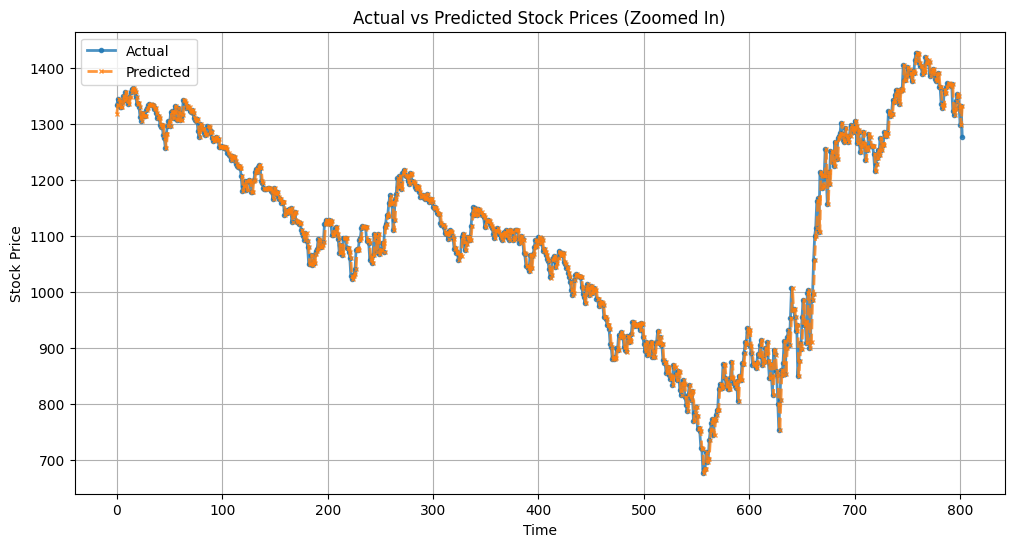

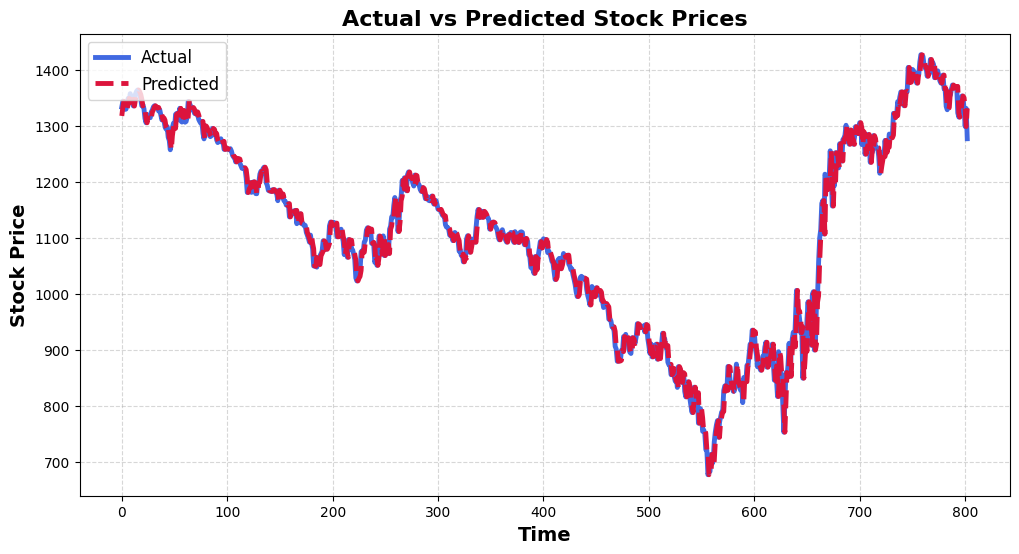

In [23]:

from tensorflow.keras.layers import Multiply, Activation

def build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1):
    inputs = Input(shape=(seq_length, 1))
    
    # Full branch (15 days)
    full_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(inputs)
    full_branch = Dense(64, activation='relu')(full_branch)
    long_term_return = Dense(1, activation='tanh')(full_branch)
    long_term_return = Lambda(lambda x: x * scale_factor)(long_term_return)
    
    # Recent branch (7 days)
    recent_input = Lambda(lambda x: x[:, -7:, :])(inputs)
    recent_branch = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(recent_input)
    recent_branch = Dense(64, activation='relu')(recent_branch)
    mid_term_return = Dense(1, activation='tanh')(recent_branch)
    mid_term_return = Lambda(lambda x: x * scale_factor)(mid_term_return)
    
    # Very recent branch (1 day)
    very_recent_input = Lambda(lambda x: x[:, -1:, :])(inputs)
    very_recent_branch = Flatten()(very_recent_input)
    very_recent_branch = Dense(32, activation='relu')(very_recent_branch)
    short_term_return = Dense(1, activation='tanh')(very_recent_branch)
    short_term_return = Lambda(lambda x: x * recent_scale)(short_term_return)
    
    # Gating mechanisms
    gate_7 = Dense(1, activation='sigmoid')(mid_term_return)
    gate_1 = Dense(1, activation='sigmoid')(short_term_return)
    gated_mid_term_return = Multiply()([mid_term_return, gate_7])
    gated_short_term_return = Multiply()([short_term_return, gate_1])
    
    # Fuse all branches
    fused_returns = Add()([long_term_return, gated_mid_term_return, gated_short_term_return])
    fused_returns = Dense(32, activation='relu')(fused_returns)
    final_return = Dense(1, activation='tanh')(fused_returns)
    final_return = Lambda(lambda x: x * scale_factor)(final_return)
    
    last_day = Lambda(lambda x: tf.expand_dims(x[:, -1, 0], axis=-1))(inputs)
    final_output = Lambda(lambda inputs: inputs[0] * (1 + inputs[1]))([last_day, final_return])
    
    model = Model(inputs, final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# *Build the Modified Model with Gating*
# model_gated = build_gated_multi_scale_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
# model_gated.summary()

# *Build the Modified Model with Attention-Based Residuals*
model_attention = build_Bilstm5_model(seq_length=15, scale_factor=0.2, recent_scale=0.1)
model_attention.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
history = model_attention.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8, callbacks=[early_stop], verbose=1)

# ---------------------------
# 7. Evaluate the Model
# ---------------------------
y_pred = model_attention.predict(X_test)
# Predictions on test set
##y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Calculate the actual range of the test set
actual_range = np.max(y_test_inv) - np.min(y_test_inv)

# Compute Scaled Metrics
mae_scaled = mae / actual_range
mse_scaled = mse / (actual_range ** 2)
rmse_scaled = rmse / actual_range

# Explained Variance Score
evs = explained_variance_score(y_test_inv, y_pred_inv) 

# Print the results
print(f"📊 Final Results -")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}, MAE Scaled: {mae_scaled:.4f}")
print(f"  MSE: {mse:.4f}, MSE Scaled: {mse_scaled:.4f}")
print(f"  RMSE: {rmse:.4f}, RMSE Scaled: {rmse_scaled:.4f}")
print(f"  MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100:.2f}%")
print(f"  EVS: {evs:.4f}")
plt.figure(figsize=(12, 6))

# Plot the first 100 points for better visibility
num_points = max(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Zoomed In)")
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(12, 6))

num_points = max(100, len(y_test_inv))

# Actual: Royal Blue
plt.plot(
    y_test_inv[:num_points], 
    label="Actual", 
    linestyle="-", 
    linewidth=3.5,  
    color="#4169E1"  # Royal Blue
)

# Predicted: Crimson Red
plt.plot(
    y_pred_inv[:num_points], 
    label="Predicted", 
    linestyle="--",  
    linewidth=3.5,  
    color="#DC143C"  # Crimson Red
)

plt.xlabel("Time", fontsize=14, fontweight="bold")
plt.ylabel("Stock Price", fontsize=14, fontweight="bold")
plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight="bold")

plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


In [ ]:
plt.figure(figsize=(12, 6))

num_points = max(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(12, 6))

num_points = max(100, len(y_test_inv))

# Actual: Royal Blue
plt.plot(
    y_test_inv[:num_points], 
    label="Actual", 
    linestyle="-", 
    linewidth=3.5,  
    color="#4169E1"  # Royal Blue
)

# Predicted: Crimson Red
plt.plot(
    y_pred_inv[:num_points], 
    label="Predicted", 
    linestyle="--",  
    linewidth=3.5,  
    color="#DC143C"  # Crimson Red
)

plt.xlabel("Time", fontsize=14, fontweight="bold")
plt.ylabel("Stock Price", fontsize=14, fontweight="bold")
plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight="bold")

plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
num_points = min(100, len(y_test_inv))

plt.plot(y_test_inv[:num_points], label="Actual", linestyle="-", linewidth=2, marker="o", markersize=3, alpha=0.8)
plt.plot(y_pred_inv[:num_points], label="Predicted", linestyle="--", linewidth=2, marker="x", markersize=3, alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid(True)

plt.show()
